## 手写数字图片生成

Copyright (c) 2023 Institute for Quantum Computing, Baidu Inc. All Rights Reserved.

### 生成模型

生成模型是机器学习中一种重要的模型类型，用于生成符合某种分布的数据。通俗地讲，生成模型可以从一些训练数据中学习到数据的分布特征，然后根据这些特征生成新的数据。

生成模型可以分为概率生成模型和非概率生成模型两种类型。概率生成模型指可以建立数据的概率分布模型的生成模型，例如常见的高斯混合模型、朴素贝叶斯模型等。这些模型通常可以通过极大似然估计等方法进行训练，然后根据模型生成符合数据分布的新数据。非概率生成模型指不依赖于概率分布模型，而是通过学习数据的特征和规律，直接生成新的数据。例如生成对抗网络（GAN）就是一种非概率生成模型，它通过两个神经网络的对抗来学习生成数据。

生成模型在自然语言处理、图像处理、音频处理等领域得到了广泛的应用。例如，可以用生成模型生成自然语言文本、图像、音频等内容，也可以用生成模型进行图像、音频的降噪、风格转换等任务。

### 使用 QCAAN 模型实现 MNIST 手写数字图片的生成

#### QCAAN 简介

量子电路关联对抗网络（Quantum-Circuit Associative Adversarial Network, QCAAN）[<sup>1</sup>](#qcaan_ref) 是一种量子生成模型，能够从现有的数据中学习，从而生成更加逼真的新数据。其可应用于数据生成、数据扩充和无监督学习。

该模型主要是基于生成对抗网络（Generative Adversarial Network, GAN）来设计的。GAN 是一种深度学习模型，主要包含生成器（Generator）和判别器（Discriminator）两个神经网络。生成器通过将从高斯分布中采样的噪音样本作为输入，生成假样本。判别器则负责对真假样本进行分类。两个网络相互博弈、不断优化，使得生成器生成的样本逐渐更加逼真。

该模型主要将 GAN 中的输入由高斯噪音分布替换为由参数化量子电路刻画的量子态分布。具体模型参考下图。除了 GAN 的两个网络外，我们还需要训练第三个量子神经网络 QNN 用来刻画生成器的输入，即先验分布 Prior，并使其接近判别器的倒数第二层隐空间（Latent space）的分布。在本教程中，我们使用的 QNN 主要包含若干层 U3 门和强纠缠门。一个包含 n qubits， D 层的量子电路可以简单地使用如下两行代码实现：

```code
cir = paddle_quantum.ansatz.Circuit(n)
cir.complex_entangled_layer(D)
```

#### QCAAN 优势

- 相较于经典的（伪）高斯分布，量子态分布是真随机，可以解决生成器（Generator）的快启动（kick-start）问题；
- 原文作者[<sup>1</sup>](#qcaan_ref) 声称使用量子态分布可以缓解 GAN 的训练不稳定问题，以致能够生成更高清、更多样的图片。

<!--![alt 量子电路关联对抗网络](qcaan_model.png "量子电路关联对抗网络")-->

<center>
    <img style="border-radius: 0.3125em;
    box-shadow: 0 2px 4px 0 rgba(34,36,38,.12),0 2px 10px 0 rgba(34,36,38,.08);" 
    src="qcaan_model.png">
    <br>
    <div style="color:orange; border-bottom: 1px solid #d9d9d9;
    display: inline-block;
    color: #999;
    padding: 2px;">量子电路关联对抗网络<sup>1</sup> 模型示意图。右边是GAN的两个网络：生成器和判别器。左边是用来刻画先验分布的量子神经网络。训练阶段，三个网络交替训练；推断阶段：先从量子神经网络中采样，然后将采样结果输入到生成器中生成逼真的图片。</div>
</center>


### 如何使用

#### 使用 QCAAN 模型进行推断

这里我们给出了一个训练好的模型，可以直接用于手写数字图片的生成。只需输入命令 
```code
python qcaan_generation.py --config inference.toml 
```
即可。

#### 在线演示
首先定义配置文件 inference.toml 的内容：

In [1]:
inference_toml = r"""
# QC-AAN 模型的整体配置文件。
# 当前配置的 mode 选择。 可以是： 'train' 或者 'inference'。这里我们选择 'inference'。
# mode = 'inference'
# 用以存储模型的模型名字
# model_name = 'qcaan-model'
# 加载训练好的模型的参数的路径。绝对路径和相对路径都可以。
params_path = "params"
# 量子电路包含的量子比特数目。
num_qubits = 8
# 量子电路包含的 complex entangled layers 的层数。
num_depths = 4
# 隐藏特征数目，表示生成器的输入的维度。
latent_dim = 16
# 人工设置种子参数用以展示模型的可复现性。
manual_seed = 20230313
"""

接下来是生成图片的代码。

每次先从训练好的 QNN 量子态中采样60个样本（注意0,1 串被放缩成1，-1串），然后输入到生成器中生成60张新图，以及随机选取40张 MNIST 中的原图作为对比。如果想换一批新图，则修改一下上面 inference.toml 文件中最后一行的 manual_seed 参数即可。

/Users/liguangxi02/opt/anaconda3/envs/PaddleQ/lib/python3.7/site-packages/paddle/tensor/creation.py:125: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this warning, use `object` by itself. Doing this will not modify any behavior and is safe. 
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  if data.dtype == np.object:



This program is running on your cpu!

Model loaded, generating new images...
The first 10 QNN samples are listed below:
 [[ 1.  1.  1. -1.  1.  1. -1.  1. -1.  1.  1. -1. -1.  1.  1. -1.]
 [ 1.  1. -1. -1.  1. -1. -1.  1.  1. -1. -1. -1. -1.  1.  1. -1.]
 [ 1.  1. -1. -1. -1. -1. -1. -1. -1.  1. -1. -1.  1. -1.  1.  1.]
 [ 1.  1.  1. -1.  1. -1. -1. -1.  1.  1.  1.  1.  1. -1. -1. -1.]
 [-1.  1.  1.  1. -1.  1. -1. -1.  1. -1. -1. -1. -1. -1. -1. -1.]
 [-1. -1.  1.  1. -1. -1. -1. -1. -1.  1. -1. -1. -1.  1. -1.  1.]
 [ 1.  1.  1. -1.  1. -1. -1.  1.  1. -1.  1. -1. -1. -1.  1.  1.]
 [-1. -1.  1. -1. -1.  1. -1. -1.  1.  1. -1. -1. -1. -1.  1. -1.]
 [ 1. -1.  1. -1.  1.  1.  1.  1. -1.  1.  1. -1.  1.  1.  1.  1.]
 [-1. -1. -1.  1.  1. -1. -1. -1.  1.  1. -1. -1.  1. -1.  1. -1.]]

The generated pictures are saved to the file named 'gen_pics/qcaan_generated_vs_original_20230313.png'.



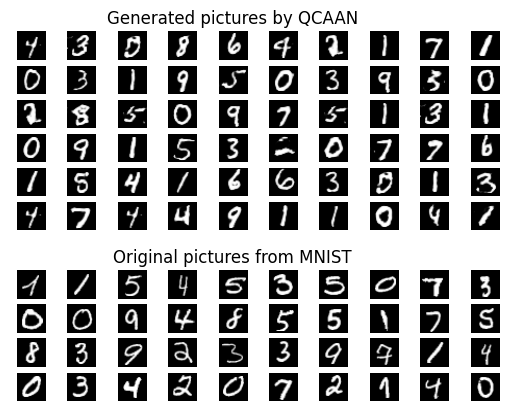

In [2]:
import os
import warnings
import toml
from paddle_quantum.qml.qcaan import model_test

warnings.filterwarnings('ignore')
os.environ['PROTOCOL_BUFFERS_PYTHON_IMPLEMENTATION'] = 'python'

config = toml.loads(inference_toml)
model_test(**config)


### 注意事项
- 这里我们给出的是已经训练好的模型。如果想自己重新训练，则只需输入命令 
```code
python qcaan_generation.py --config train.toml 
```
即可。其中，也可以对文件 train.toml 进行修改，以设置不同的训练参数。
- 如果想换个数据集测试模型，则需要查看源码文件 ./paddle_quantum/qml/qcaan.py，并对其中加载数据集部分重新设置一下，可能还需要对模型网络架构，超参数等进行微调。

### 参考文献

<div id="qcaan_ref"></div>

- [1] Rudolph, Manuel S., et al. "Generation of high-resolution handwritten digits with an ion-trap quantum computer." Physical Review X 12.3 (2022): 031010.